<a href="https://colab.research.google.com/github/MpRonald/Machine-Learning/blob/main/Time_Series_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet Algorithm

In [ ]:
!pip install -U pandas-datareader plotly

In [ ]:
!pip install prophet

In [3]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime
yahoo_data = DataReader('JPM',  'yahoo', datetime(2001,6,1), datetime(2021,6,1))
yahoo_df = yahoo_data['Adj Close'].to_frame().reset_index('Date')

In [4]:
yahoo_df.dtypes

Date         datetime64[ns]
Adj Close           float64
dtype: object

In [5]:
from prophet import Prophet
forecaster = Prophet().fit(yahoo_df.rename(columns={"Date": "ds", "Adj Close": "y"}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
future = forecaster.make_future_dataframe(periods=90)
forecast = forecaster.predict(future)

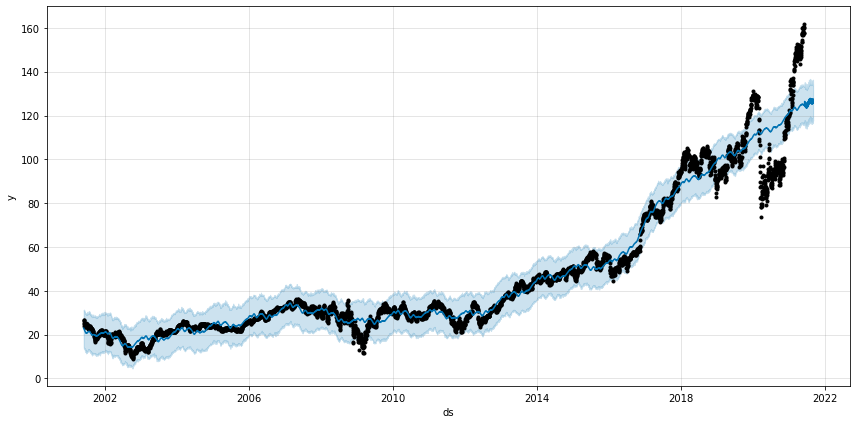

In [7]:
forecaster.plot(forecast, figsize=(12, 6));

# Markov Algorithm

In [10]:
from statsmodels.tsa.regime_switching.tests.test_markov_autoregression import rgnp
import seaborn as sn
import pandas as pd
dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq='QS')
dta_hamilton = dta.rgnp 

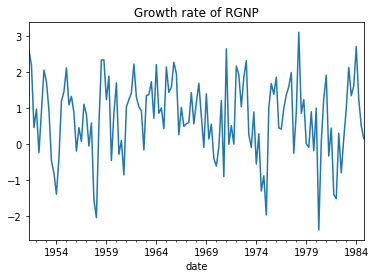

In [13]:
dta_hamilton.plot(title='Growth rate of RGNP');

In [14]:
dta.head()

,rgnp,date,recession
date,,,
1951-04-01,2.593164,1951-04-01,0
1951-07-01,2.202171,1951-07-01,0
1951-10-01,0.458276,1951-10-01,0
1952-01-01,0.968744,1952-01-01,0
1952-04-01,-0.241308,1952-04-01,0


In [15]:
# Vamos ajustar o modelo de comutação de Markov de 4ª ordem . Especificaremos dois regimes:
import statsmodels.api as sm
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [16]:
print(res_hamilton.summary())

                         Markov Switching Model Results                         
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Fri, 20 May 2022   AIC                            380.527
Time:                          16:27:09   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 

In [17]:
res_hamilton.expected_durations

array([ 4.07604744, 10.42589388])

A saída array([ 4.07604793, 10.4258926 ])está nos trimestres financeiros. Portanto, espera-se que uma recessão leve cerca de quatro trimestres (1 ano) e uma expansão 10 trimestres (dois anos e meio).

Em seguida, vamos traçar a probabilidade de recessão em cada ponto no tempo. No entanto, isso é mais informativo se sobrepusermos os indicadores de recessão do National Bureau of Economic Research (NBER), que podemos carregar com o pandas-dataloader:

In [18]:
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

In [20]:
usrec.head()

,USREC
DATE,
1947-01-01,0
1947-02-01,0
1947-03-01,0
1947-04-01,0
1947-05-01,0


Nas primeiras cinco linhas, não houve recessão de acordo com os indicadores NBER.

Bem agoraplotar indicadores de recessão NBER contra as previsões do regime do modelo:

[(0.0, 1.0),
 (712679.0, 724550.0),
 Text(0.5, 1.0, 'Filtered probability of recession')]

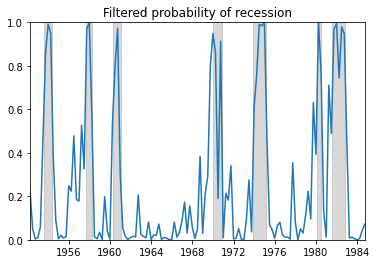

In [25]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1) 
ax.plot(res_hamilton.filtered_marginal_probabilities[0]) 
ax.fill_between(
  usrec.index, 0, 1, where=usrec['USREC'].values,
  color='gray', alpha=0.3
)
ax.set(
  xlim=(dta_hamilton.index[4], dta_hamilton.index[-1]),
  ylim=(0, 1),
  title='Filtered probability of recession'
)

Podemos ver láparece ser uma boa combinação entre as previsões do modelo e os indicadores reais de recessão.

# Série temporal difusa


### Nesta seção, vamoscarregar duas séries temporais de símbolos de ticker, os índices NASDAQ e S&P 500, ao longo do tempo e preverusando o algoritmo de 1993 de Song e Chissom. Isso segue de perto o tutorial de exemplo na biblioteca.

In [ ]:
!pip install pyFTS SimpSOM

In [2]:
from pyFTS.data import NASDAQ, SP500
datasets = {"SP500": SP500.get_data()[11500:16000],"NASDAQ": NASDAQ.get_data()}

In [4]:
train_split = 2000

In [5]:
# Vamos definir umoperação de diferenciação de primeira ordem para pré-processamento:

from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

In [19]:
# O próximo passo é treinar nossos modelos para as duas séries temporais transformadas (diferenciadas):

from pyFTS.models import song
from pyFTS.partitioners import Grid
models = {}
for count, (dataset_name, dataset) in enumerate(datasets.items()):
  partitioner_diff = Grid.GridPartitioner(data=dataset, npart=15, transformation=tdiff)
  model = song.ConventionalFTS(partitioner=partitioner_diff)
  model.name = dataset_name
  model.append_transformation(tdiff)
  model.fit(dataset[:train_split], order=1)
  models[dataset_name] = model

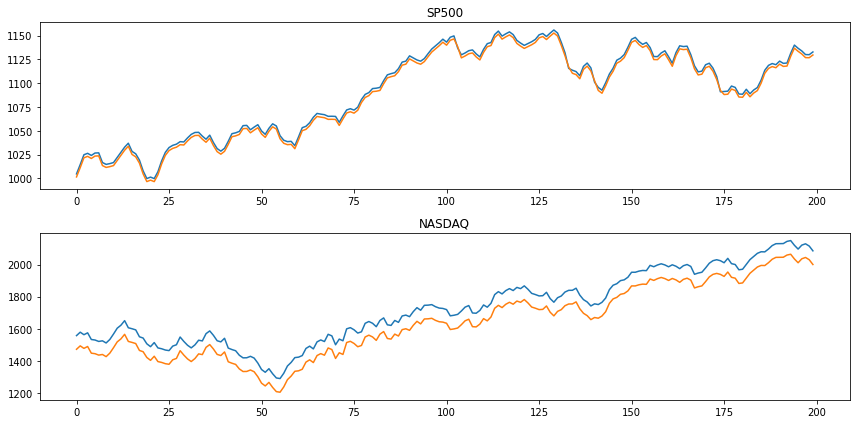

In [53]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=[12, 6])
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    ax[count].plot(dataset[train_split:train_split+200])
    model = models[dataset_name]
    forecasts = model.predict(dataset[train_split:train_split+200], steps_ahead=1)
    ax[count].plot(forecasts)
    ax[count].set_title(dataset_name)
    
plt.tight_layout()

In [24]:
# PyFTStem uma função de conveniência para extrair RMSE, MAPE e,
# finalmente, U de Theil, uma medida de correlação.
import pandas as pd
from pyFTS.benchmarks import Measures
rows = []
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    row = [dataset_name]
    test = dataset[train_split:train_split+200]
    model = models[dataset_name]
    row.extend(Measures.get_point_statistics(test, model))
    rows.append(row)
    
pd.DataFrame(rows,columns=["Dataset", "RMSE", "MAPE", "Theil's U"]).set_index("Dataset")

,RMSE,MAPE,Theil's U
Dataset,,,
SP500,6.76,0.52,1.22
NASDAQ,90.85,5.14,3.79


# Modelagem Bayesiana de Séries Temporais Estruturais


### Neste exemplo, vamosaplicar modelagem BSTS paracompreender o efeito causal do tratamento em séries temporais.


Aqui, estaremos estimando o impacto do escândalo de emissões de setembro de 2015 para a Volkswagen. Trabalharemos com os valores das ações de três grandes empresas, Volkswagen, BMW e Allianz. oO conjunto de dados vem com a biblioteca Python Causal Impact (tfcausalimpact):

In [ ]:
!pip install tfcausalimpact

In [26]:
import pandas as pd
from causalimpact import CausalImpact
data = pd.read_csv("https://raw.githubusercontent.com/WillianFuks/tfcausalimpact/master/tests/fixtures/volks_data.csv",\
                   header=0, sep=' ', index_col='Date', parse_dates=True)

In [28]:
!pip install matplotlib

In [46]:
!pip -m pip uninstall matplotlib
!pip install matplotlib


Usage:   
  pip3 <command> [options]

no such option: -m


In [47]:
import matplotlib.pyplot as plt

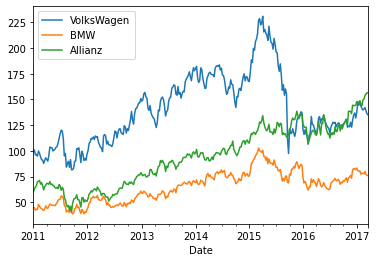

In [56]:
data.plot()

In [58]:
# Vamos tentar descobrir o impacto real do escândalo das emissões. 
# Podemos construir nosso modelo assim:
import numpy as np
pre_period = [str(np.min(data.index.values)), "2015-09-13"]
post_period = ["2015-09-20", str(np.max(data.index.values))]
ci = CausalImpact(data.iloc[:, 0], pre_period, post_period, model_args={'nseasons': 52, 'fit_method': 'vi'})

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


In [59]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.91             10026.07
Prediction (s.d.)         172.85 (13.3)      13654.93 (1051.05)
95% CI                    [146.9, 199.05]    [11605.13, 15725.19]

Absolute effect (s.d.)    -45.94 (13.3)      -3628.87 (1051.05)
95% CI                    [-72.14, -19.99]   [-5699.12, -1579.07]

Relative effect (s.d.)    -26.58% (7.7%)     -26.58% (7.7%)
95% CI                    [-41.74%, -11.56%] [-41.74%, -11.56%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


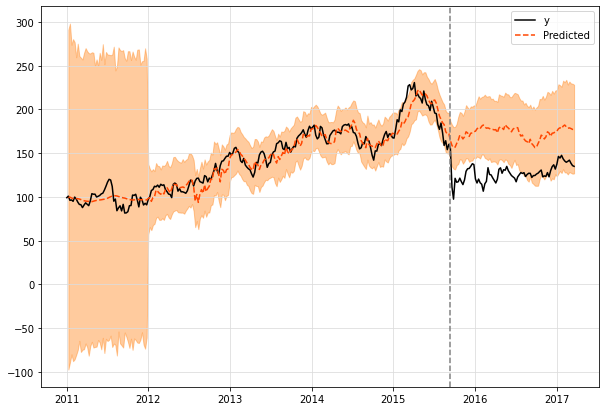

In [61]:
ci.plot(panels=["original"])

a série temporal original em relação ao valor contrafactual previsto.